# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

PyTorch version: 2.1.0+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20
BATCH_SIZE: int = 32

In [4]:
resources_folder = 'resources/classification'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

print(len(data))
print(data[0].shape)
print(data[0][0].shape)

loaded numpy bitmaps, 8 classes
8
(144722, 784)
(784,)


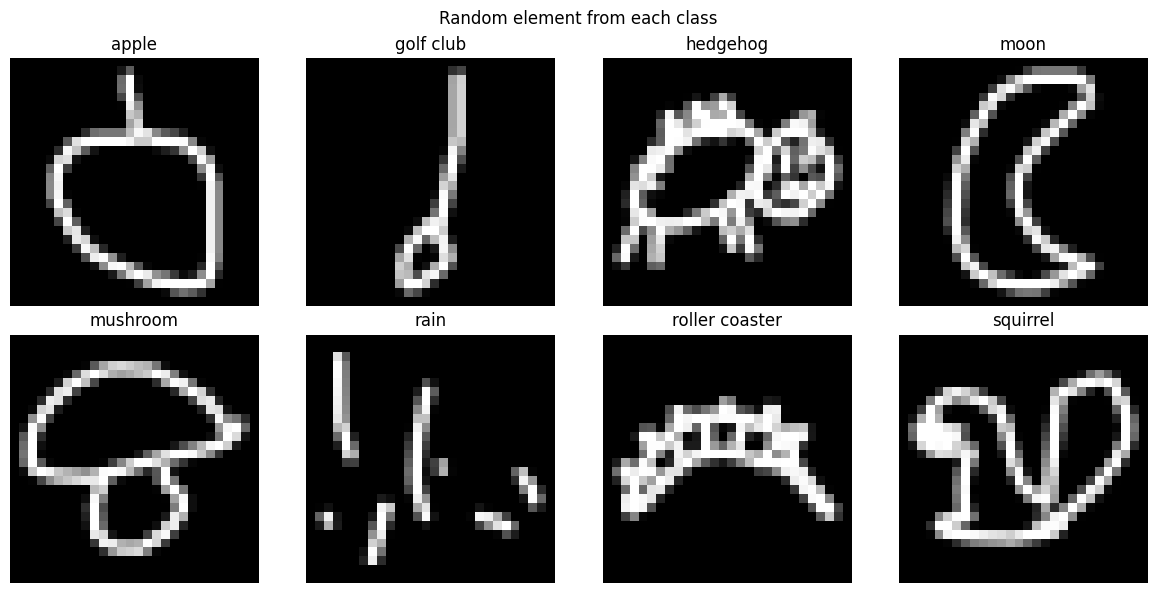

In [5]:
to_plot = []

for class_data in data:
    array = random.choice(class_data).reshape(WIDTH, HEIGHT)
    to_plot.append(array)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(classes[i])

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManager import DataManager

data_manager = DataManager()

split = 0.8
training_data, training_labels, validation_data, validation_labels = data_manager.split_data(split, data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')

training dataset size : 927239
validation dataset size : 231814


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

In [8]:
from dataset_creation.GraysacleDataset import GrayscaleDataset

len_subset = 2000
valid_test_subset = 500

training_set = GrayscaleDataset(data=shuffled_training_data[:len_subset], labels=shuffled_training_labels[:len_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)
validation_set = GrayscaleDataset(data=shuffled_validation_data[:valid_test_subset], labels=shuffled_validation_labels[:valid_test_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)

## Autoencoder class

In [9]:
from src.linear_autoencoder import LinearAutoencoder
from src.linear_autoencoder_embed import LinearAutoencoderEmbed

## Try with simple model

In [10]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT // 2]
#autoencoder_model = LinearAutoencoder(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True, encode_class=True)
autoencoder_model = LinearAutoencoderEmbed(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.3, batch_norm=True, class_number=len(classes))
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [11]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / architecture_1[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=392, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=392, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 2.0


In [12]:
num_epochs = 40
autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40]	Loss: 0.0796	Test Loss 0.0744	Train PSNR: 11.7894	Train SSIM: 0.1732	Validation PSNR: 11.7312	Validation SSIM: 0.1594
Epoch [2/40]	Loss: 0.0539	Test Loss 0.0508	Train PSNR: 13.0141	Train SSIM: 0.2160	Validation PSNR: 12.8739	Validation SSIM: 0.1979
Epoch [3/40]	Loss: 0.0421	Test Loss 0.0474	Train PSNR: 14.2373	Train SSIM: 0.3010	Validation PSNR: 13.9680	Validation SSIM: 0.2746
Epoch [4/40]	Loss: 0.0383	Test Loss 0.0354	Train PSNR: 15.2862	Train SSIM: 0.3572	Validation PSNR: 14.9022	Validation SSIM: 0.3267
Epoch [5/40]	Loss: 0.0283	Test Loss 0.0313	Train PSNR: 16.2088	Train SSIM: 0.4105	Validation PSNR: 15.6727	Validation SSIM: 0.3759
Epoch [6/40]	Loss: 0.0248	Test Loss 0.0240	Train PSNR: 17.0334	Train SSIM: 0.4489	Validation PSNR: 16.3713	Validation SSIM: 0.4123
Epoch [7/40]	Loss: 0.0193	Test Loss 0.0216	Train PSNR: 17.7880	Train SSIM: 0.4881	Validation PSNR: 16.9617	Validation SSIM: 0.4492
Epoch [8/40]	Loss: 0.0142	Test Loss 0.0189	Train PSNR: 18.5080	Train SSIM: 0.5172	V

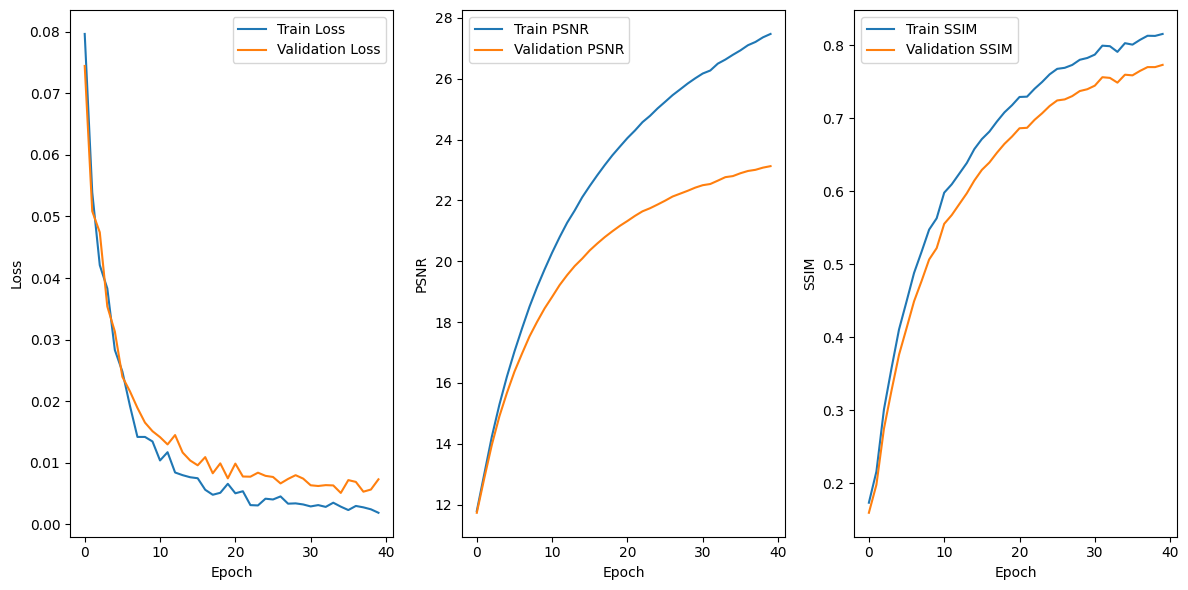

In [13]:
# plot Train and Test Loss, PSNR and SSIM values
autoencoder_model.plot_psnr_ssim()

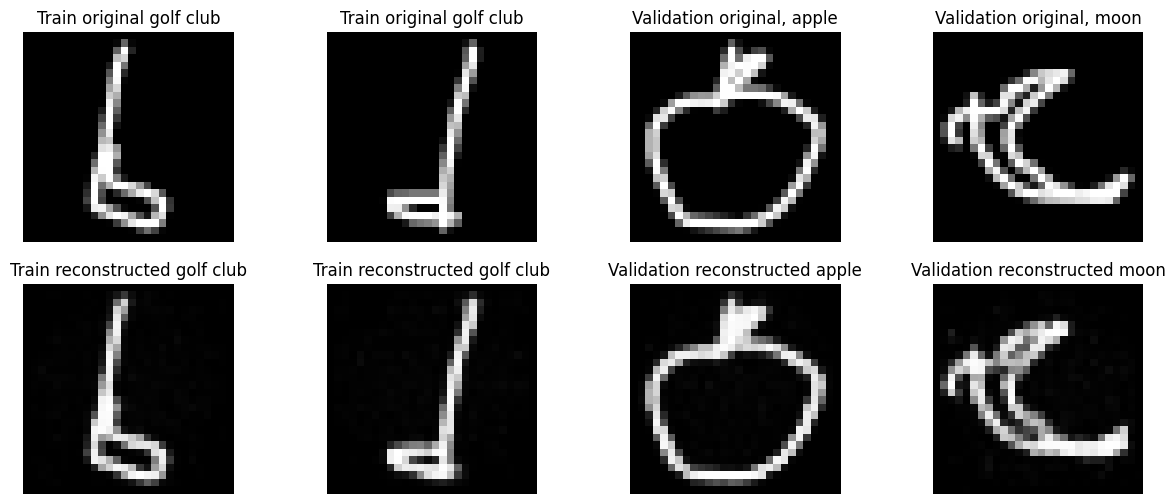

In [14]:
# plot some original and reconstructed images
autoencoder_model.show_images(training_set, validation_set)

In [15]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [16]:
# Show the lowest psnr then ssim in the test set
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]} | {lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]} | {lowest_ssim[1]}')

Lowest PSNR index: 493 | 14.861810107544713, Lowest SSIM index: 473 | 0.408658954749799


[493, 14.861810107544713]
[473, 0.408658954749799]


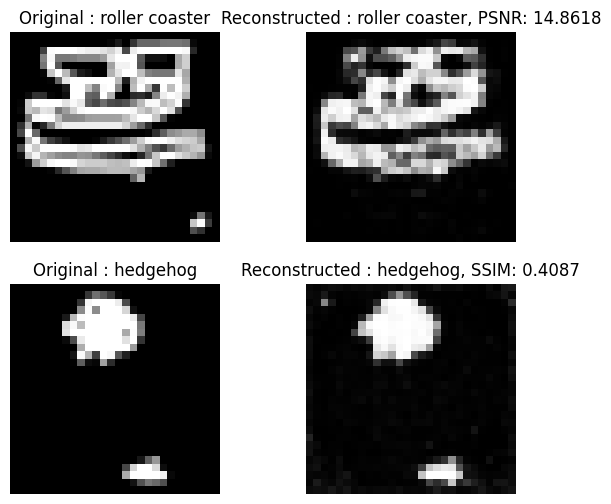

In [17]:
# Show image with the lowest psnr and ssim compared to their original the test set on same plot
print(lowest_psnr)
print(lowest_ssim)
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Try with a different model architecture

In [18]:
layers = [WIDTH * HEIGHT, WIDTH * HEIGHT // 2, WIDTH * HEIGHT // 4]
autocoder_model2 = LinearAutoencoderEmbed(layers, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True, class_number=len(classes))
autocoder_model2.to(device)

# Define loss function and optimizer

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autocoder_model2.parameters(), lr=0.001)

# Print architecture
autocoder_model2.print_model()

# Compression factor
print(f'Compression factor: {WIDTH * HEIGHT / autocoder_model2.architecture[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=392, bias=True)
  (encoder_relu_0): ReLU()
  (encoder_dropout_0): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_0): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder_1): Linear(in_features=392, out_features=196, bias=True)
)
Sequential(
  (decoder_2): Linear(in_features=196, out_features=392, bias=True)
  (decoder_relu_2): ReLU()
  (encoder_dropout_2): Dropout(p=0.1, inplace=False)
  (encoder_batchnorm_2): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_1): Linear(in_features=392, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 4.0


In [19]:
# Call the function
num_epochs = 40

autocoder_model2.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40]	Loss: 0.1302	Test Loss 0.1364	Train PSNR: 9.3645	Train SSIM: 0.1086	Validation PSNR: 9.2849	Validation SSIM: 0.0962
Epoch [2/40]	Loss: 0.0627	Test Loss 0.0571	Train PSNR: 12.9289	Train SSIM: 0.1680	Validation PSNR: 12.7935	Validation SSIM: 0.1499
Epoch [3/40]	Loss: 0.0448	Test Loss 0.0537	Train PSNR: 13.7679	Train SSIM: 0.2207	Validation PSNR: 13.5575	Validation SSIM: 0.1969
Epoch [4/40]	Loss: 0.0520	Test Loss 0.0446	Train PSNR: 14.2733	Train SSIM: 0.2773	Validation PSNR: 13.9729	Validation SSIM: 0.2472
Epoch [5/40]	Loss: 0.0450	Test Loss 0.0360	Train PSNR: 14.7817	Train SSIM: 0.3210	Validation PSNR: 14.3820	Validation SSIM: 0.2896
Epoch [6/40]	Loss: 0.0347	Test Loss 0.0355	Train PSNR: 15.2087	Train SSIM: 0.3517	Validation PSNR: 14.7039	Validation SSIM: 0.3165
Epoch [7/40]	Loss: 0.0542	Test Loss 0.0392	Train PSNR: 15.4990	Train SSIM: 0.3836	Validation PSNR: 14.9106	Validation SSIM: 0.3443
Epoch [8/40]	Loss: 0.0363	Test Loss 0.0358	Train PSNR: 15.8083	Train SSIM: 0.4164	Val

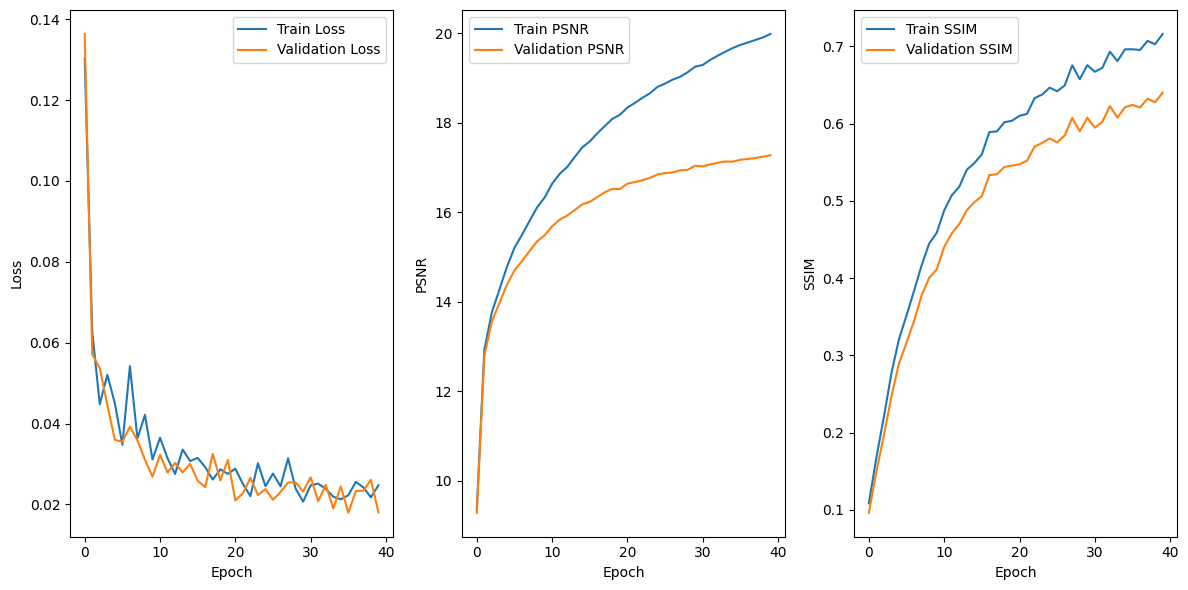

In [20]:
autocoder_model2.plot_psnr_ssim()

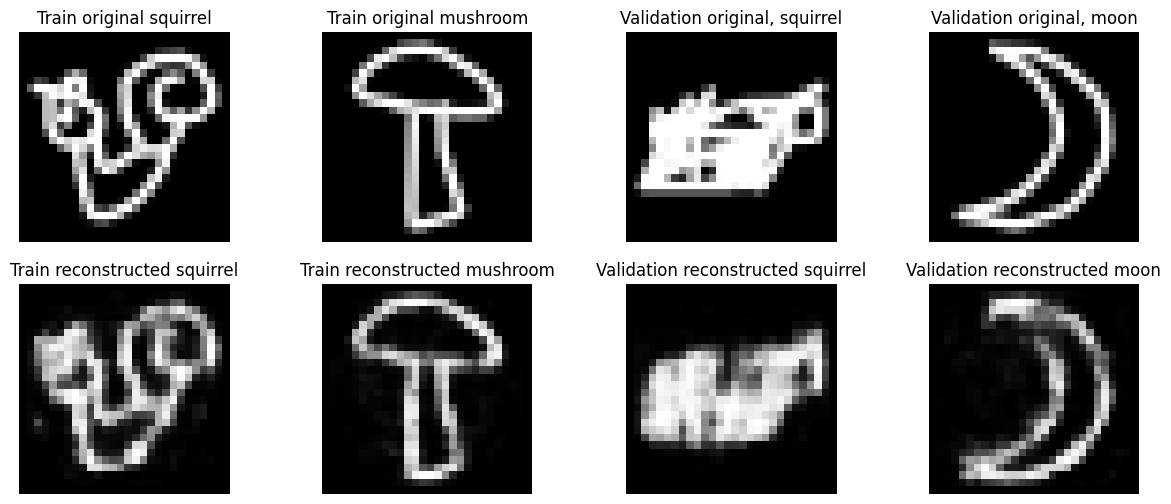

In [21]:
autocoder_model2.show_images(training_set, validation_set)

Lowest PSNR index: 185|11.695324553710309, Lowest SSIM index: 493|0.30981450350486917


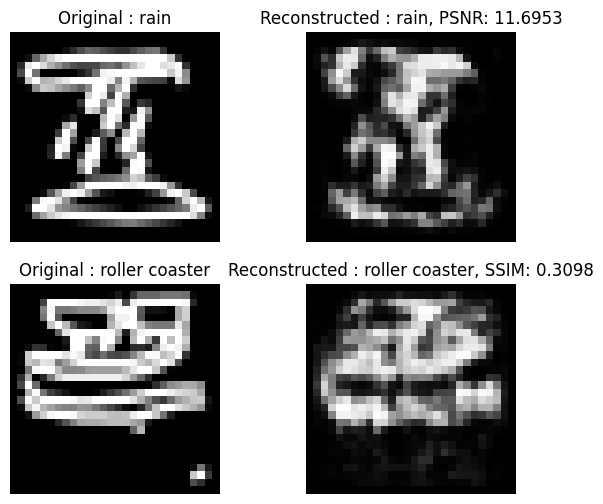

In [22]:
lowest_psnr, lowest_ssim = autocoder_model2.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]}|{lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]}|{lowest_ssim[1]}')

autocoder_model2.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Generating images

In [23]:
def return_classes_mean_encoded_vector(model, images_set):
    mean_encoded_vectors = []
    mean_vectors_size = model.architecture[-1]
    count_classes_number = [0] * nb_classes

    for i in range(nb_classes):
        mean_encoded_vectors.append(np.zeros(mean_vectors_size))

    for batch in images_set:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        encoded, decoded = model(images, labels=labels)
        encoded_np = encoded.cpu().detach().numpy()

        for i in range(len(images)):
            mean_encoded_vectors[labels[i]] += encoded_np[i]
            count_classes_number[labels[i]] += 1
            
    for i in range(nb_classes):
        mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i]

        print(f'Class {classes[i]} range of mean encoded vector: [{mean_encoded_vectors[i].min()}, {mean_encoded_vectors[i].max()}]')

    return mean_encoded_vectors

def generated_images_for_mean_vector(mean_encoded_vectors, model):
    generated_images = []

    decoder = model.decoder
    for i in range(nb_classes):
        mean_vector = mean_encoded_vectors[i]
        double_mean_vector = np.array([mean_vector]).astype(np.float32)
        mean_vector_torch = torch.from_numpy(double_mean_vector).to(device)

        decoded = decoder(mean_vector_torch)

        generated_images.append(decoded.cpu().detach().numpy()[0].reshape(HEIGHT, WIDTH))

    return generated_images

def show_generated_images(generated_images):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    for i in range(nb_classes):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].imshow(generated_images[i], cmap='gray')
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(classes[i])

    plt.tight_layout()
    plt.suptitle('Generated images')

    plt.subplots_adjust(top=0.9)

    plt.show()

In [24]:
def create_alternative_version(mean_vector, weight=0.1):
    alternative_mean_vector = mean_vector.copy()
    # Vector is composed of float values 
    # use gaussian distribution to generate altertivate vector based on mean one

    for i in range(len(mean_vector)):
        alternative_mean_vector[i] = np.random.normal(mean_vector[i], weight)
    
    return alternative_mean_vector

Class apple range of mean encoded vector: [-3.4828164135004234, 2.903719555342562]
Class golf club range of mean encoded vector: [-2.678596469458569, 2.826001199108831]
Class hedgehog range of mean encoded vector: [-2.851094374656677, 3.1974110448360444]
Class moon range of mean encoded vector: [-3.276174926396572, 2.9873090922230423]
Class mushroom range of mean encoded vector: [-2.674352334506476, 3.034785521564199]
Class rain range of mean encoded vector: [-2.7928069793017563, 4.021407372128647]
Class roller coaster range of mean encoded vector: [-4.287733783679349, 3.481496974825859]
Class squirrel range of mean encoded vector: [-2.9690663258367556, 2.837036976447472]


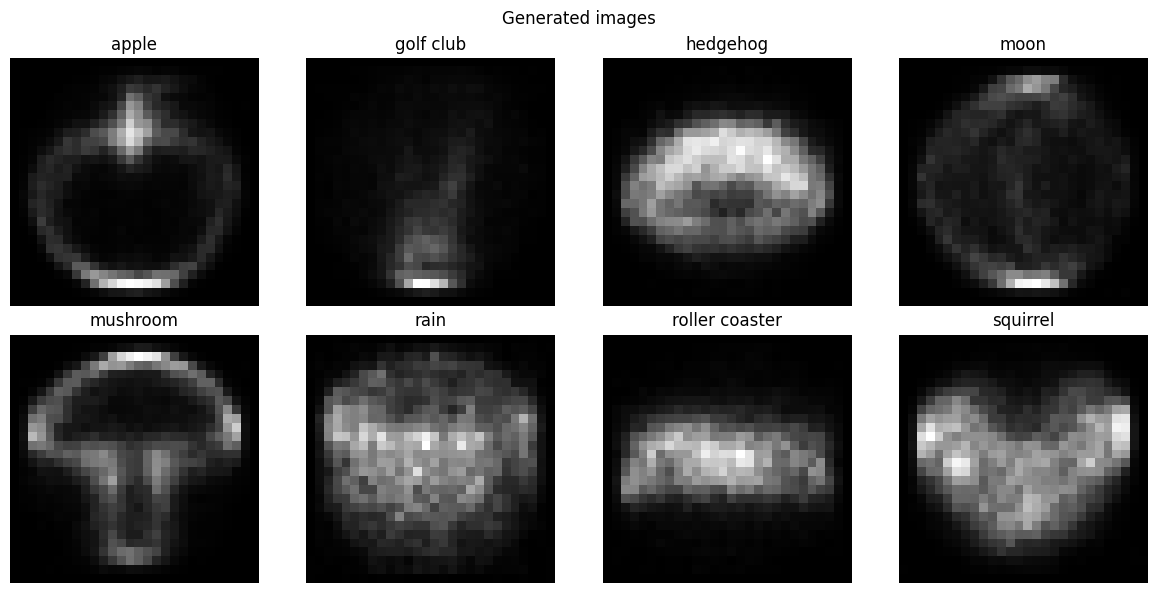

In [25]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

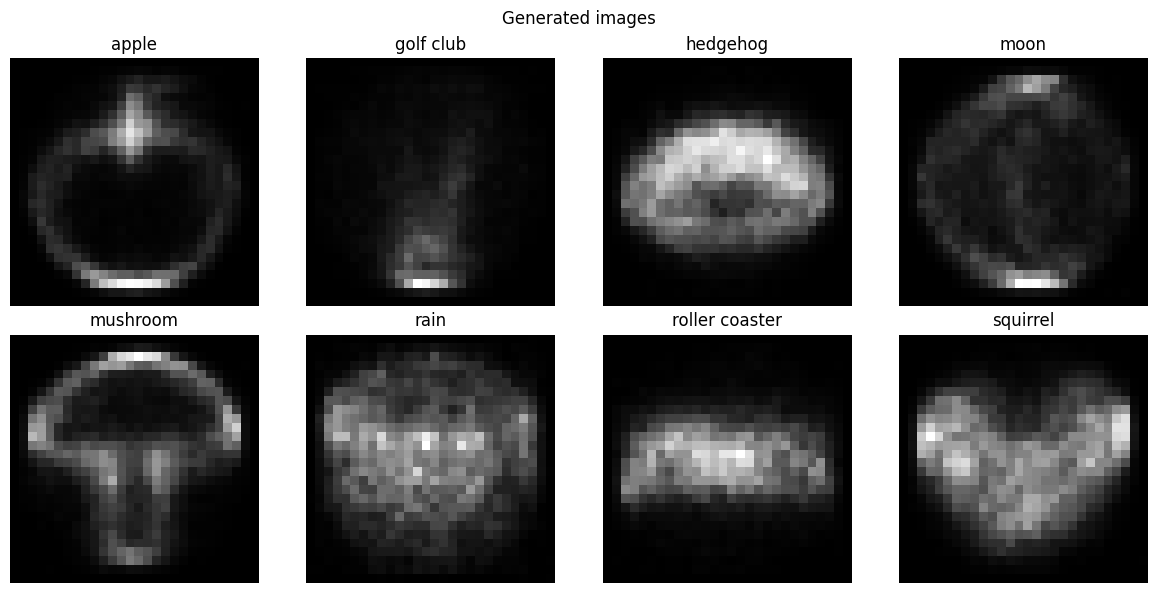

In [26]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)

In [27]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autocoder_model2, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autocoder_model2)
show_generated_images(generated_images)

Class apple range of mean encoded vector: [-2.7227548001635022, 2.645745166524529]
Class golf club range of mean encoded vector: [-2.9844627407159696, 3.317121788357081]
Class hedgehog range of mean encoded vector: [-3.4985119181871416, 3.2636468753218653]
Class moon range of mean encoded vector: [-2.6399844776500356, 3.2885267048171074]
Class mushroom range of mean encoded vector: [-2.461408473217665, 2.812257098395433]
Class rain range of mean encoded vector: [-2.124719136847859, 3.291100932433542]
Class roller coaster range of mean encoded vector: [-2.4510546632643258, 3.008655642292329]
Class squirrel range of mean encoded vector: [-3.1061866329266477, 2.436639704433173]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x196 and 392x784)

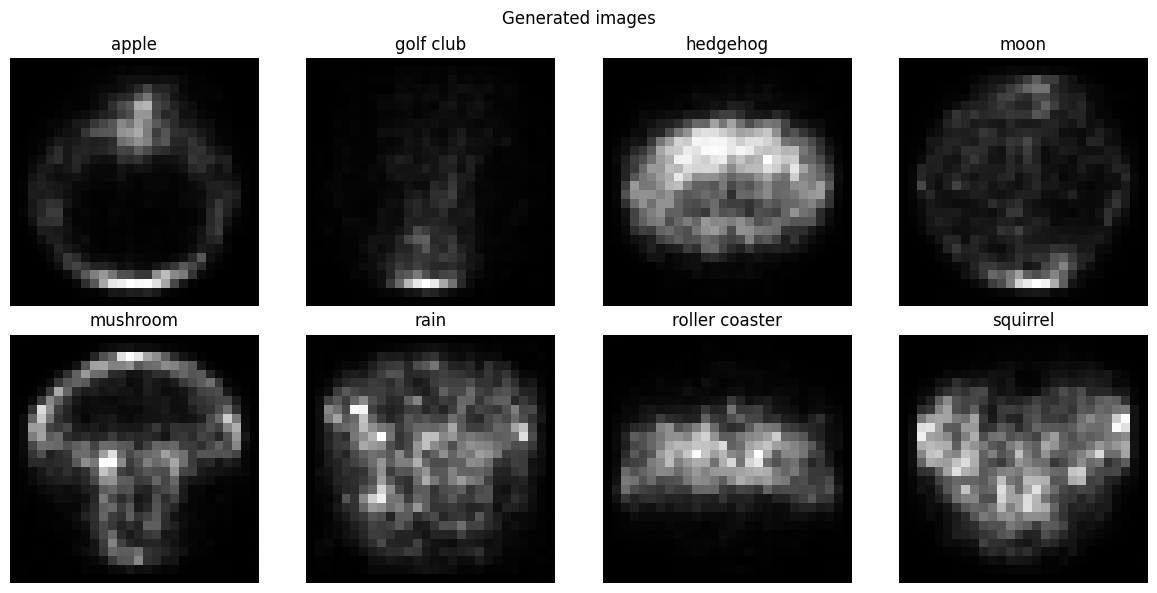

In [ ]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autocoder_model2)
show_generated_images(alternative_generated_version)